In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.cluster import KMeans, SpectralClustering

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src.downsample import downsamp_audio
import src.embedding_extractor as ee
import src.dimension_reducer as dr
import src.distance_metrics as dm

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

one_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/one_samp_toy_downsamp' #toy dataset with one participant recording @16kHz
#two_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/two_samp_toy_downsamp'#toy dataset with two participant recordings @16kHz
two_samp_toy_dir ='/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/020422_postpartum_moms_two_samp_toy'
down_sampled_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/downsamp'#all the data, downsampled to 16kHz
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings' #location of embeddings save new embeddings load pre-generated ones from here
emb_models = ['emb_ami', 'emb','emb_voxceleb'] #names of pretrained embedding extractor models

##files starting with 020422 are from the recent recordings of actual moms sohye sent
## files starting with 020322 were all the test recordings from last year

#the directory has other csvs and i only want today's
file = [file for file in os.listdir(embedding_dir) if file.startswith("020422")] 

#create a dictionary where each item is the pd df of the embeddings extracted from that model
all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}

Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master


In [2]:
## Downsample embeddings if desired for all embedding models in the dictionary. The function will shuffle all the emebddings for one participant and then average N_to_avg together.
#if N_to_avg=1 then the embeddings are just shuffled (recommended to try to dissasociate embeddings from the same utterance, though maybe doesn't matter

emb_down = {model:ee.resample_data(emb,1) for model, emb in all_embs.items()}
emb_down[emb_models[0]]


,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,part_id
0,0.052308,0.077886,0.000251,0.015853,-0.348656,-0.335287,0.127277,0.247500,0.491464,0.309206,...,0.073462,0.187235,0.053176,0.282077,0.109794,-0.086190,-0.079246,0.124128,0.011277,1.0
1,0.339089,0.226846,-0.157339,0.247275,0.282102,-0.309417,-0.024487,0.102217,0.496059,0.659860,...,-0.053071,0.209392,0.302244,0.298100,0.143768,0.382500,0.291479,-0.098412,-0.081741,1.0
2,-0.191872,-0.365431,0.035704,0.073347,0.071339,-0.180764,-0.086051,0.122339,0.196173,-0.107497,...,-0.353899,0.191347,-0.066299,-0.229395,0.191400,-0.300896,0.098188,0.104238,-0.105709,1.0
3,-0.247606,-0.282234,-0.192288,0.072305,0.090145,-0.016672,0.113710,-0.062874,0.059867,-0.515502,...,-0.562370,-0.257239,-0.124880,-0.124246,-0.121974,-0.361113,0.019221,0.090611,-0.096552,1.0
4,0.204259,0.133047,-0.026584,0.210914,0.221772,-0.223052,-0.033916,0.146366,0.468797,0.463362,...,-0.074060,0.278727,0.308324,0.317282,0.191068,0.203313,0.136408,-0.049699,-0.146437,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1474,-0.001885,-0.213092,-0.110205,0.067188,0.350817,-0.258751,-0.211907,-0.101445,0.255190,0.286957,...,-0.161834,0.034220,0.033280,0.141002,0.246717,0.186491,0.034070,-0.046845,0.167976,20.0
1475,0.212489,-0.071449,-0.178116,-0.029687,0.569796,-0.324935,-0.391724,-0.311743,0.235074,-0.005170,...,-0.168140,-0.293537,-0.175431,0.106640,0.063776,0.162209,0.000514,-0.259789,-0.197670,20.0
1476,0.072517,0.029241,0.001097,-0.091724,0.214873,-0.351371,-0.013635,-0.298535,0.144767,-0.063476,...,-0.238317,-0.173778,-0.075594,0.418214,0.001841,0.085250,0.061795,-0.046004,0.001896,20.0
1477,0.089232,-0.239771,-0.204647,0.086302,0.222511,-0.165203,0.248919,0.238821,0.296416,0.403025,...,0.278955,-0.199337,0.411458,0.365313,0.155374,0.112590,0.135185,0.025843,-0.106233,20.0


In [3]:
##Run variations of tSNE from Kobak & Berens 2019 'The art of using t-SNE for single-cell transcriptomics'
#perpexity = 30, init='random',learning_rate=200
emb_tsne_def = {mod:dr.run_tsne(ed) for mod, ed in emb_down.items()}

#**perpexity = n/100**, init='random',learning_rate=200
emb_tsne_1pp = {mod:dr.run_tsne(ed, perplexity = -(-ed.shape[0]//100)) for mod, ed in emb_down.items()}

#perpexity = 30, **init='pca'**,learning_rate=200
emb_tsne_pca = {mod:dr.run_tsne(ed, init='pca') for mod, ed in emb_down.items()}

#**multiscale: perpexity = n/100, **init='pca'**,learning_rate=200**
#should be perplexity = n/100 when n/100>>30
emb_tsne_multi = {mod:dr.run_tsne(ed, perplexity = -(-ed.shape[0]//100), init='pca', learning_rate=ed.shape[0]//12) for mod, ed in emb_down.items()}

In [4]:
#Run UMAP to compare
emb_umap = {model:dr.run_umap(ed) for model, ed in emb_down.items()}

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
#calculate hausdorf distances for all models and default dimension reduction techniques
haus_tsne = {model:dm.hausdorff_distances(e2d) for model, e2d in emb_tsne_def.items()}

haus_umap = {model:dm.hausdorff_distances(e2d) for model, e2d in emb_umap.items()}

haus_tsne = {model: haus.where(np.triu(np.ones(haus.shape), k=1).astype(np.bool)) for model, haus in haus_tsne.items()}
haus_tsne_flat = {model: haus.stack().reset_index() for model, haus in haus_tsne.items()}

Processing row 16, col 16


In [ ]:
## try to implement KNN, KNC, CPD metrics to evaluate dim reduc from https://github.com/berenslab/rna-seq-tsne/blob/master/toy-example.ipynb
dist = []

[dist.append(
    dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(), 
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),
        subsetsize=100
    )
) 
 for (X,Z) in zip(emb_down.values(), emb_tsne_def.values())
]

[dist.append(
    dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(), 
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),
        subsetsize=100
    )
) 
 for (X,Z) in zip(emb_down.values(), emb_tsne_1pp.values())
]

[dist.append(
    dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(), 
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),
        subsetsize=100
    )
) 
 for (X,Z) in zip(emb_down.values(), emb_tsne_pca.values())
]

[dist.append(
    dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(),
        Z.drop(columns='part_id').to_numpy(),
        X.part_id.to_numpy(),
        subsetsize=100
    )
) 
 for (X,Z) in zip(emb_down.values(), emb_tsne_multi.values())
]

[dist.append(
    dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(), 
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),
        subsetsize=100
    )
) 
 for (X,Z) in zip(emb_down.values(), emb_umap.values())
]


dist = pd.DataFrame(dist, index = emb_models*5, columns = ['micro', 'meso', 'macro'])
#dist = pd.DataFrame(dist, index = emb_models*4, columns = ['knn', 'knc', 'cpd','dim_reduc'])

In [20]:
dist[dist.index == 'emb_ami'] 

,micro,meso,macro
emb_ami,0.482623,0.776471,0.681294
emb_ami,0.479919,0.776471,0.592728
emb_ami,0.486207,0.752941,0.695139
emb_ami,0.484381,0.741176,0.573615
emb_ami,0.380325,0.547059,0.287893


In [21]:
dist[dist.index == 'emb']

,micro,meso,macro
emb,0.288677,0.850000,0.563329
emb,0.280787,0.811111,0.555570
emb,0.288342,0.844444,0.583994
emb,0.280228,0.844444,0.556067
emb,0.141037,0.611111,0.041977


In [22]:
dist[dist.index == 'emb_voxceleb']

,micro,meso,macro
emb_voxceleb,0.484990,0.747059,0.675681
emb_voxceleb,0.487086,0.747059,0.591195
emb_voxceleb,0.485463,0.741176,0.705552
emb_voxceleb,0.484855,0.747059,0.543948
emb_voxceleb,0.386072,0.605882,0.356502


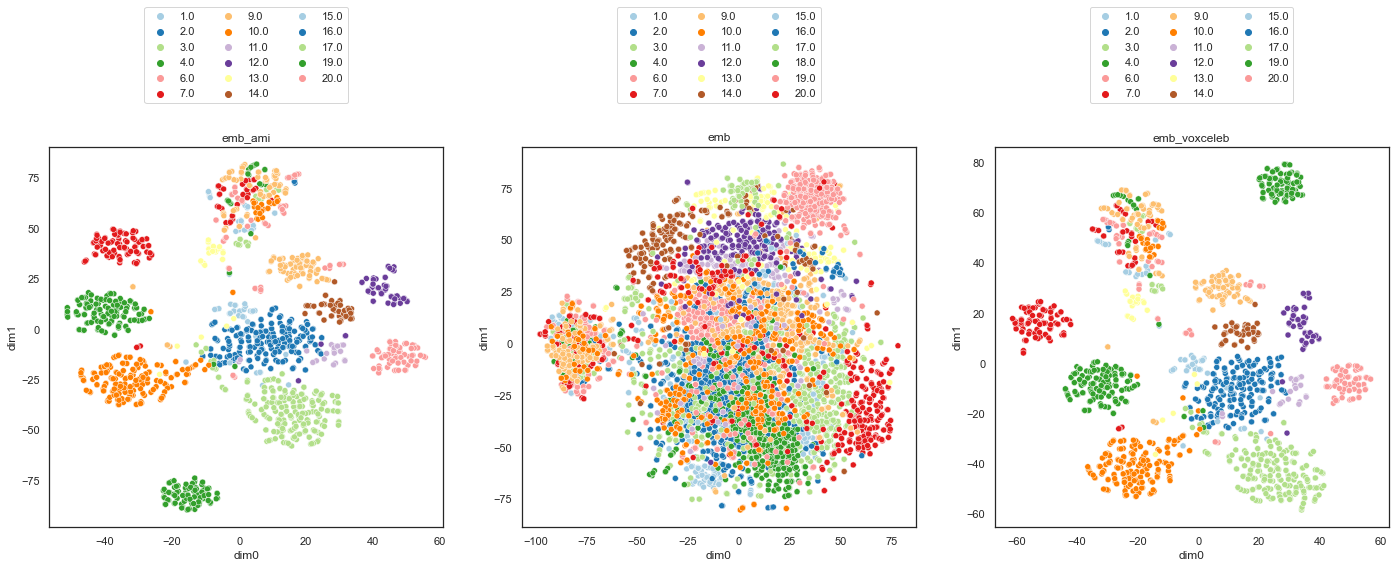

In [23]:
df = emb_tsne_def
sns.set_theme(style="white")
fig, ax = plt.subplots(ncols=3, figsize=(24,7))
[sns.scatterplot(x=df[model].dim0, y=df[model].dim1, palette="Paired", hue=df[model].part_id, ax=ax[emb_models.index(model)]).set(title=model) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)for model in emb_models]

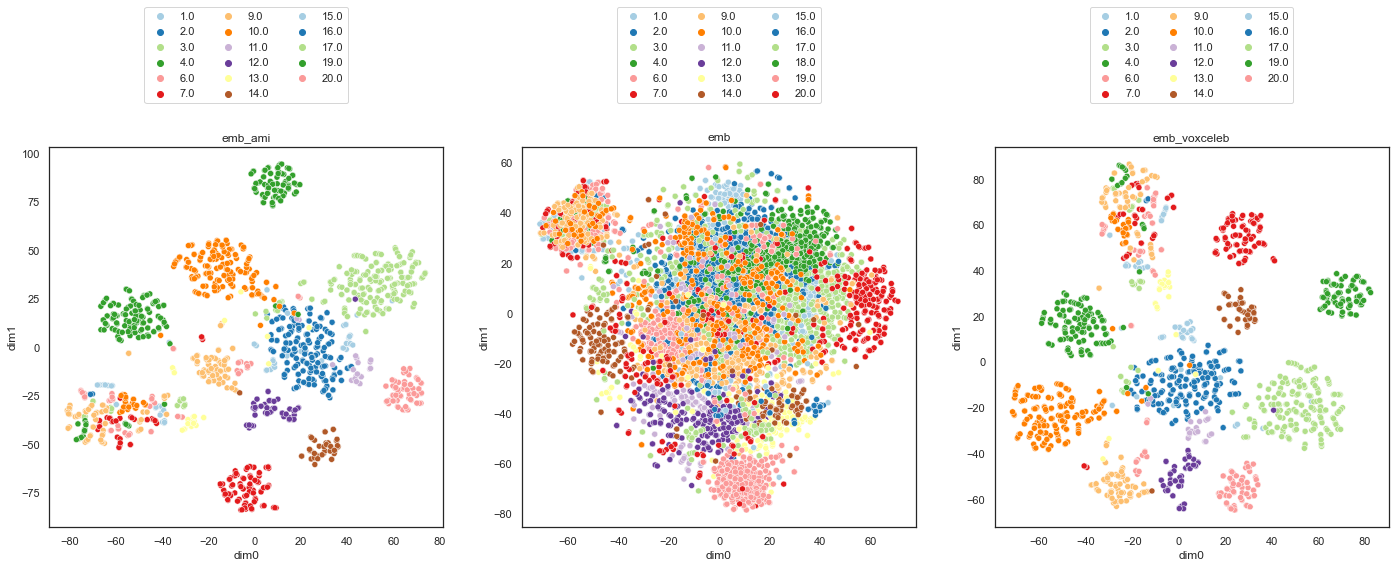

In [24]:
df = emb_tsne_1pp

sns.set_theme(style="white")
fig, ax = plt.subplots(ncols=3, figsize=(24,7))

[sns.scatterplot(x=df[model].dim0, y=df[model].dim1, palette="Paired", hue=df[model].part_id, ax=ax[emb_models.index(model)]).set(title=model) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)for model in emb_models]

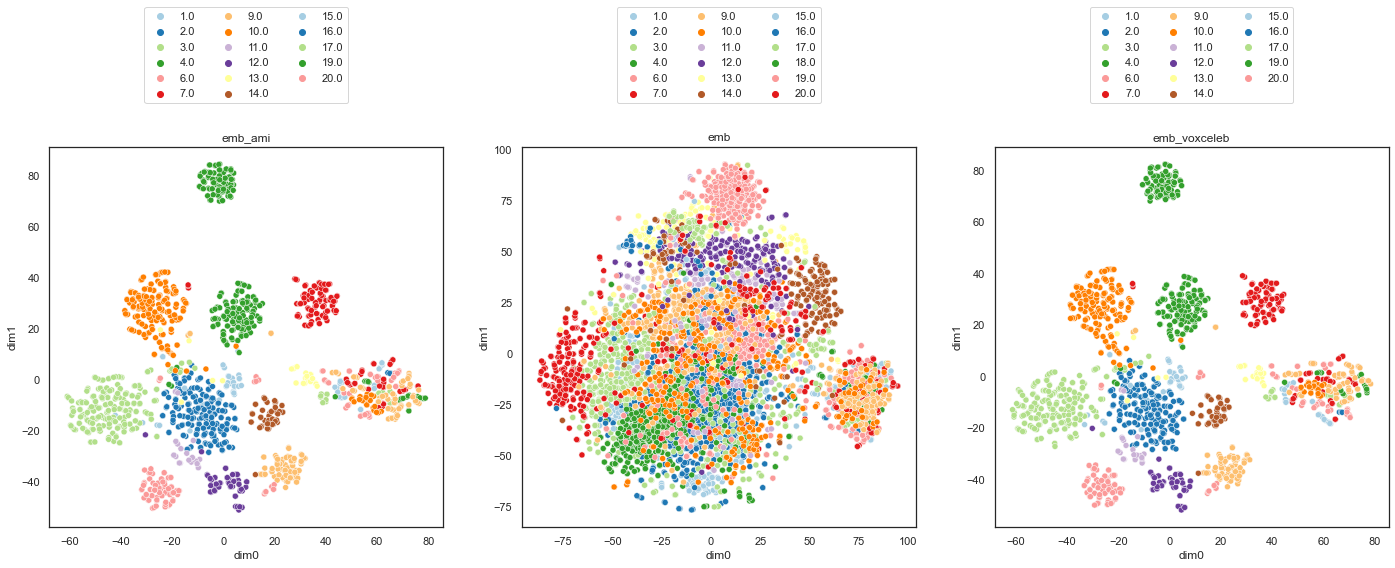

In [25]:
df = emb_tsne_pca

sns.set_theme(style="white")
fig, ax = plt.subplots(ncols=3, figsize=(24,7))

[sns.scatterplot(x=df[model].dim0, y=df[model].dim1, palette="Paired", hue=df[model].part_id, ax=ax[emb_models.index(model)]).set(title=model) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)for model in emb_models]

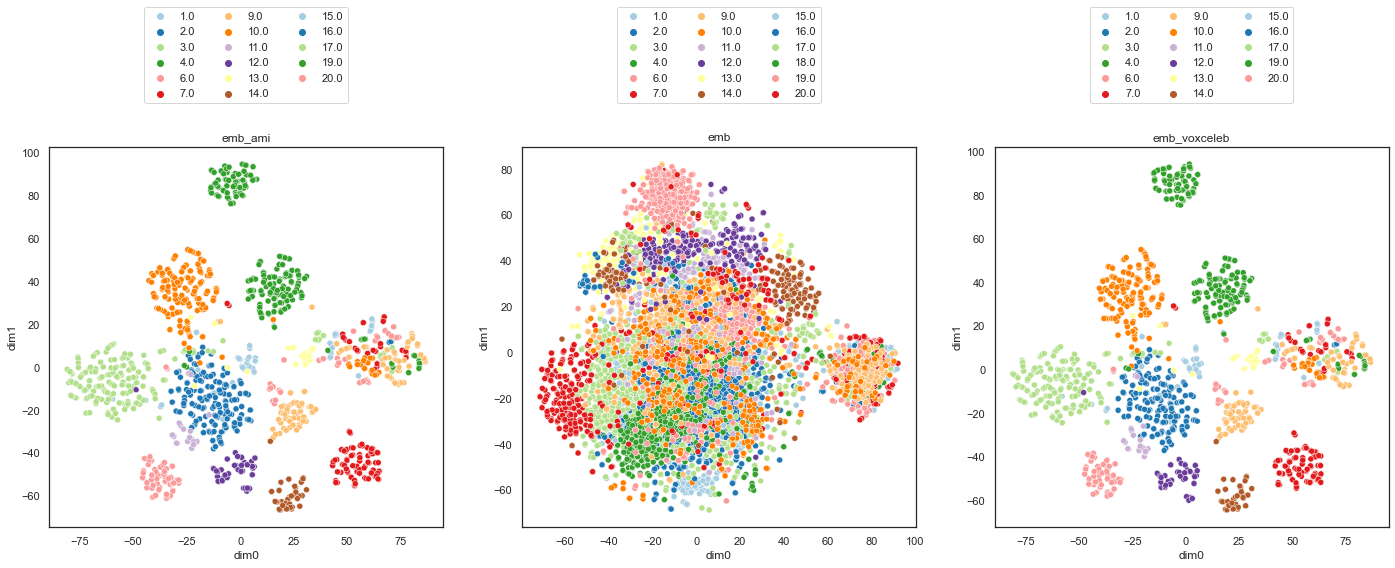

In [26]:
df = emb_tsne_multi

sns.set_theme(style="white")
fig, ax = plt.subplots(ncols=3, figsize=(24,7))

[sns.scatterplot(x=df[model].dim0, y=df[model].dim1, palette="Paired", hue=df[model].part_id, ax=ax[emb_models.index(model)]).set(title=model) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)for model in emb_models]

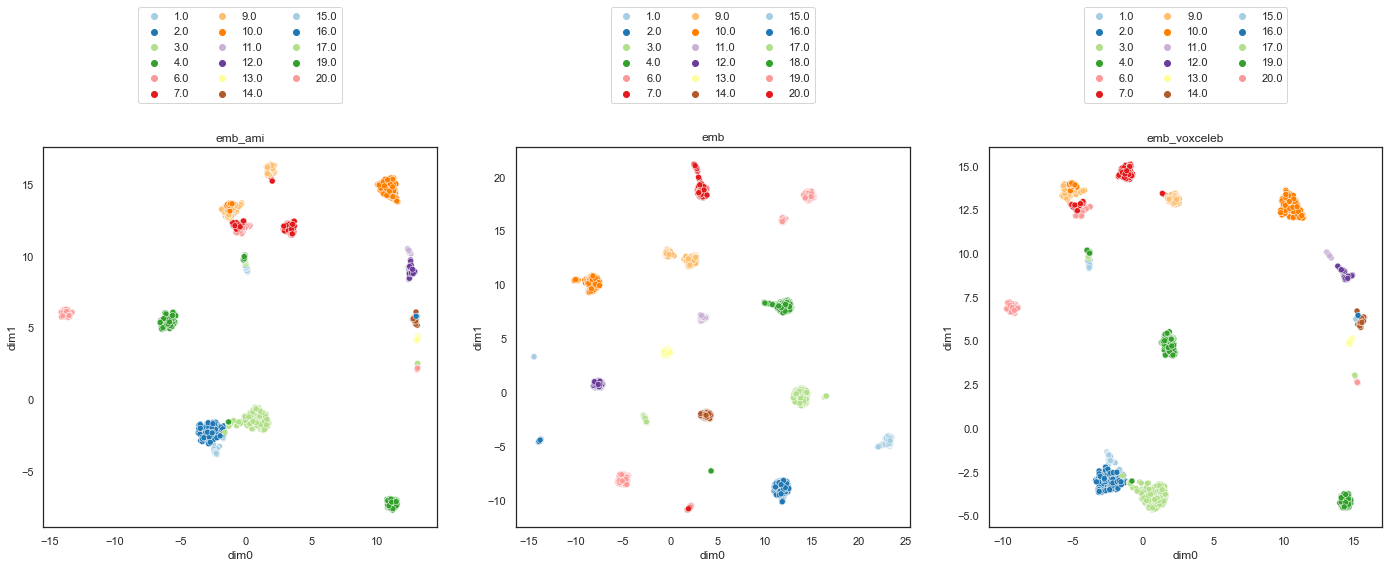

In [27]:
df = emb_umap

sns.set_theme(style="white")
fig, ax = plt.subplots(ncols=3, figsize=(24,7))

[sns.scatterplot(x=df[model].dim0, y=df[model].dim1, palette="Paired", hue=df[model].part_id, ax=ax[emb_models.index(model)]).set(title=model) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)for model in emb_models]